# Kanji Radical Match

Data processing, training, and output.

In [1]:
import utils as u
import torch.nn as nn
import torch

eng_to_rads = dict(list(u.load_eng_to_rads().items())[:10])
# print(eng_to_rads)
eng_tens, rad_tens, eng_vocab, rad_vocab = u.dict_to_tensors(eng_to_rads)

print(eng_tens)
print(eng_vocab)
print(rad_tens)

tensor([[0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])
['eight' 'enter' 'insert' 'nine' 'one' 'one radical (no.1)' 'person'
 'seven' 'two' 'two radical (no. 7)']
tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 1.,
         0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0.],
        [0., 1., 0., 0., 1., 0., 1., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0.,
         0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0.],
        [0.,

In [3]:
u.get_tensor_from_word("eight", eng_tens, eng_vocab)

tensor([1., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [4]:

from utils import KanjiFFNN
import torch.optim as optim
import torch.nn as nn

e2r_model = KanjiFFNN(eng_tens.size(1), rad_tens.size(1), 20)
criterion = nn.BCELoss()

optimizer = optim.SGD(e2r_model.parameters(), lr=0.01)

In [5]:
epochs = 30000

# Now train the model

for idx in range(0, epochs):
    for input, target in zip(eng_tens, rad_tens):
        optimizer.zero_grad()   # zero the gradient buffers
        output = e2r_model(input)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()    # Does the update
    if idx % 1000 == 0:
        print("Epoch {: >8} Loss: {}".format(idx, loss.data.numpy()))

Epoch        0 Loss: 0.7021975517272949
Epoch     1000 Loss: 0.0885620266199112
Epoch     2000 Loss: 0.0461355559527874
Epoch     3000 Loss: 0.019489405676722527
Epoch     4000 Loss: 0.009421957656741142
Epoch     5000 Loss: 0.005656171590089798
Epoch     6000 Loss: 0.0039030667394399643
Epoch     7000 Loss: 0.002929406240582466


KeyboardInterrupt: 

In [ ]:

torch.save(e2r_model, "model.pt")

In [7]:
e2r_model(torch.tensor([0., 0., 0., 0., 1., 0., 0., 0., 0., 0.]))

tensor([0.5533, 0.5253, 0.4726, 0.5685, 0.4467, 0.4639, 0.4836, 0.4546, 0.5685,
        0.5521, 0.5721, 0.5171, 0.5698, 0.5153, 0.5267, 0.5873, 0.4215, 0.5261,
        0.4731], grad_fn=<SigmoidBackward0>)

In [16]:
torch.save(e2r_model.state_dict(), "model_state_dict.pt")

In [6]:
loaded_model = KanjiFFNN(eng_tens.size(1), rad_tens.size(1), 20)
loaded_model.load_state_dict(torch.load('model_state_dict.pt'))
loaded_model.eval()

KanjiFFNN(
  (hid1): Linear(in_features=10, out_features=20, bias=True)
  (hid2): Linear(in_features=20, out_features=19, bias=True)
)

In [36]:
tensor = u.get_tensor_from_word("eight", eng_tens, eng_vocab)
res = loaded_model(tensor)
print(res)

tensor([0.5591, 0.4698, 0.4397, 0.6316, 0.4401, 0.4499, 0.4236, 0.4984, 0.5486,
        0.5337, 0.5656, 0.4989, 0.5549, 0.4954, 0.5761, 0.5790, 0.4719, 0.4749,
        0.5423], grad_fn=<SigmoidBackward0>)


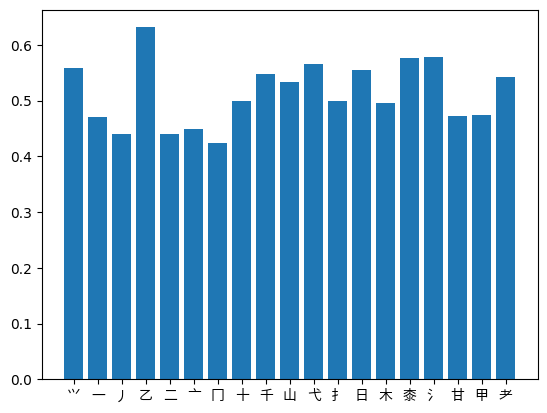

In [37]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
fprop = fm.FontProperties(fname='NotoSansCJKtc-Regular.otf')
names = rad_vocab
values = res.tolist()

fig, axs = plt.subplots()
axs.bar(names, values)
axs.set_xticks(range(len(names)), names, fontproperties=fprop)
plt.show()